**To download and untar the dataset in colab:**

```bash
! mkdir -P /content/drive/MyDrive/datasets/deepsig
! wget -P /content/drive/MyDrive/datasets/deepsig https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld
! mv /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2?Authorization=3_20221227213905_2c795ffc54e9046c69c5217c_469e51be5cab6f465d8a532240da083f077ea3dc_002_20221227223905_0027_dnld /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
! tar -xvf /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2 -C /content/drive/MyDrive/datasets/deepsig/RML2016.10b
! rm /content/drive/MyDrive/datasets/deepsig/RML2016.10b.tar.bz2
```

> Note : 
> The link will not work, you will have to request a link from the website.

# Imports and Constants

In [2]:
import pickle

import numpy as np
import scipy as sci
from scipy.integrate import cumulative_trapezoid

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gc

ROOT = '/kaggle/input/rml2016'
DAT = ROOT + '/RML2016.10b.dat'

# Loading and exploring the data

In [3]:
# from https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb
# modified for python 3
Xd = pickle.load(open(DAT, 'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
del Xd, snrs, mods
X = np.vstack(X)
y = np.array(lbl)
del lbl
gc.collect()

X.shape, y.shape

((1200000, 2, 128), (1200000, 2))

In [4]:
# The labels
print(f'{np.unique(y[:,0],return_counts=True)}\n\n\
{np.unique(y[:,1],return_counts=True)}')

(array(['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16',
       'QAM64', 'QPSK', 'WBFM'], dtype='<U21'), array([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
       120000, 120000]))

(array(['-10', '-12', '-14', '-16', '-18', '-2', '-20', '-4', '-6', '-8',
       '0', '10', '12', '14', '16', '18', '2', '4', '6', '8'],
      dtype='<U21'), array([60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000, 60000,
       60000, 60000]))


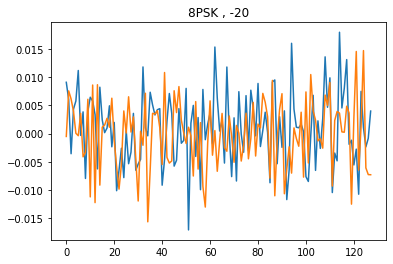

In [5]:
plt.plot(X[0,0])
plt.plot(X[0,1])
plt.title(f'{y[0,0]} , {y[0,1]}')
plt.show()

## Signal derivative

In [6]:
d_np = np.gradient(X[0,0])

lines=[d_np,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'derivative'))
fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Signal Integral

In [7]:
i_ct = cumulative_trapezoid(X[0,0])

lines=[i_ct,X[0,0]]

t = np.linspace(0,127,128)

fig = go.Figure()
fig.add_trace(go.Line(x=t,y=lines[0],name=f'cumulative trapezoid'))

fig.add_trace(go.Line(x=t,y=lines[1],name=f'original signal'))

fig.show()

# Creating Feature Spaces

Possible feature spaces:

1. raw signal
2. derivative
3. integration
4. raw and derivative
5. raw and integration
6. derivative and integration
7. raw and derivative and integration


In [5]:
X_diff = np.gradient(X,axis=-1)
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

X_raw_diff = np.concatenate((X,X_diff),axis=1)
X_raw_int = np.concatenate((X,X_int),axis=1)
X_diff_int = np.concatenate((X_diff,X_int),axis=1)

X_all = np.concatenate((X,X_diff,X_int),axis=1)

print(f'\
Shapes\n\
X_raw: {X.shape}\n\
X_diff: {X_diff.shape}\n\
X_int: {X_int.shape}\n\n\
X_raw_diff: {X_raw_diff.shape}\n\
X_raw_int: {X_raw_int.shape}\n\
X_diff_int: {X_diff_int.shape}\n\n\
X_all: {X_all.shape}')

Shapes
X_raw: (1200000, 2, 128)
X_diff: (1200000, 2, 128)
X_int: (1200000, 2, 128)

X_raw_diff: (1200000, 4, 128)
X_raw_int: (1200000, 4, 128)
X_diff_int: (1200000, 4, 128)

X_all: (1200000, 6, 128)


In [9]:
'''del X_diff
del X_int

del X_raw_diff
del X_raw_int
del X_diff_int

del X_all'''

'del X_diff\ndel X_int\n\ndel X_raw_diff\ndel X_raw_int\ndel X_diff_int\n\ndel X_all'

# Data Splitting

In [6]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1, stratify = y[:,0])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.05, random_state =1, stratify = y_train[:,0])
    return x_train, x_val, x_test, y_train, y_val, y_test

# Models

## Hyperparameters

In [7]:
EPOCHS = 80
PATIENCE = 6
LEARNING_RATE = 0.0009

## CNN model

In [19]:
def create_cnn(name,cnn_input_shape):
    cnn_model = keras.Sequential([
        layers.Conv2D(64,
                    kernel_size=3,
                    activation='relu',
                      padding='same',
                    input_shape=cnn_input_shape),
        layers.Conv2D(16,
                     kernel_size=3,
                      strides=2,
                      padding='same',
                     activation='relu'),
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ],name=name)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    cnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(cnn_model.summary())
    return cnn_model
    
# TODO: questions: 
# is it conv1D
# 1. Padding?
# 2. what is x1  and x2 in 2nd and 3rd layer? kernel size or number of Conv?

In [23]:
x = X
cnn_model = create_cnn("cnn_2_ch",x.shape[1:]+(1,))

Model: "cnn_2_ch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 128, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 64, 16)         9232      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 142,362
Trainable params: 142,362
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
values = np.linspace(0.00001,LEARNING_RATE,20)[::-1]
boundaries = np.linspace(5, 100,19)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

In [9]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=np.array(x_train),
        y=y_train,
        epochs=epochs,
        validation_data=(np.array(x_val),y_val),
        callbacks=[lr_scheduler,checkpoint, early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [13]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

NameError: name 'x' is not defined

In [8]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

NameError: name 'y_test' is not defined

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 204s 8ms/step - loss: 1.0845 - accuracy: 0.5380 - val_loss: 1.1046 - val_accuracy: 0.5284
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 209s 8ms/step - loss: 1.0824 - accuracy: 0.5386 - val_loss: 1.1110 - val_accuracy: 0.5280
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 199s 8ms/step - loss: 1.0812 - accuracy: 0.5393 - val_loss: 1.1067 - val_accuracy: 0.5235
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 192s 8ms/step - loss: 1.0795 - accuracy: 0.5401 - val_loss: 1.1078 - val_a

[1.1032196283340454, 0.5328571200370789]

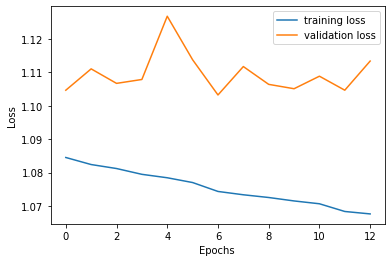

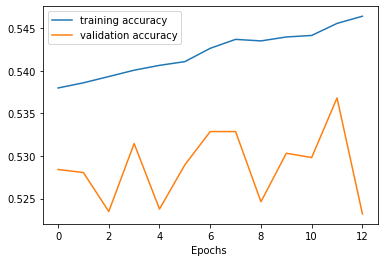

In [20]:
cnn_history = train_and_plot(
    cnn_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train
cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

In [21]:
# cnn_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.1032 - accuracy: 0.5329


[1.1032196283340454, 0.5328571200370789]

## Test Results

In [11]:
def eval_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape+(1,)))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

              precision    recall  f1-score   support

        8PSK       0.34      0.40      0.37     36000
      AM-DSB       0.49      0.75      0.59     36000
        BPSK       0.46      0.68      0.55     36000
       CPFSK       0.64      0.64      0.64     36000
        GFSK       0.59      0.69      0.64     36000
        PAM4       0.84      0.69      0.76     36000
       QAM16       0.45      0.21      0.29     36000
       QAM64       0.53      0.56      0.54     36000
        QPSK       0.48      0.41      0.44     36000
        WBFM       0.56      0.26      0.35     36000

    accuracy                           0.53    360000
   macro avg       0.54      0.53      0.52    360000
weighted avg       0.54      0.53      0.52    360000



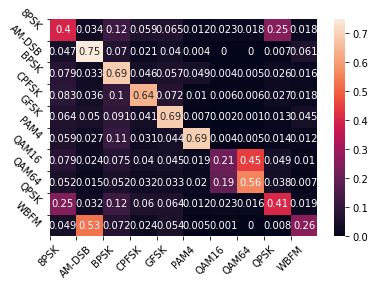

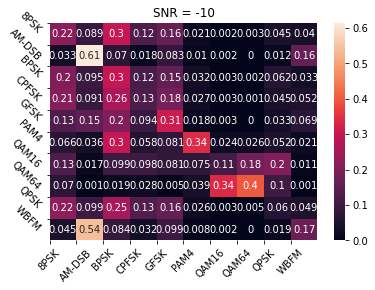

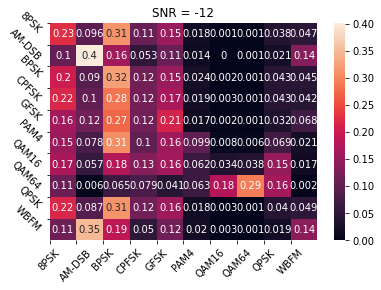

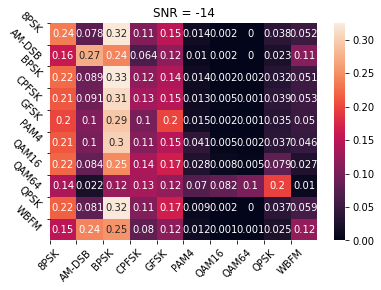

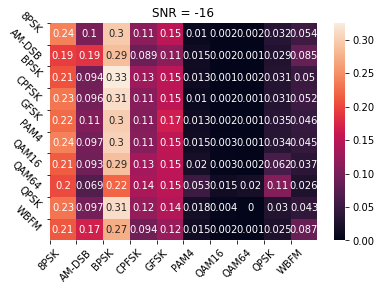

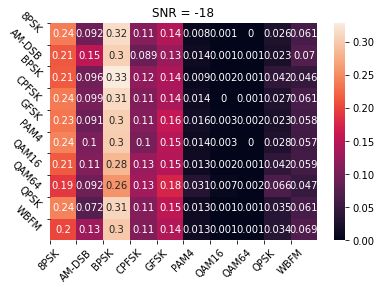

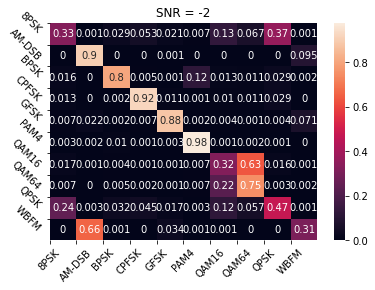

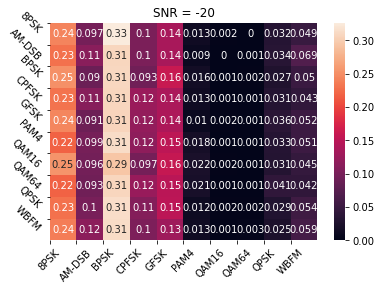

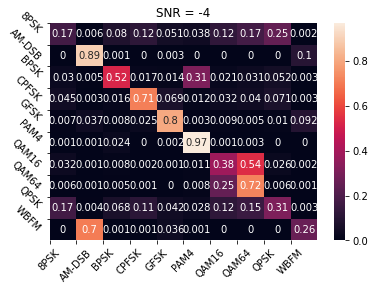

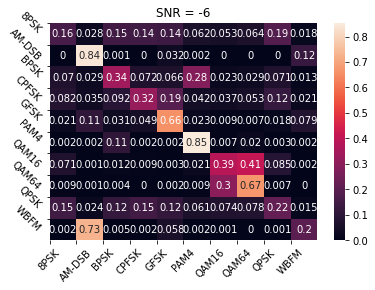

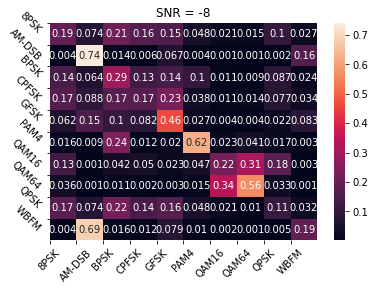

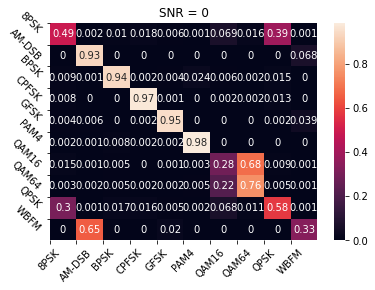

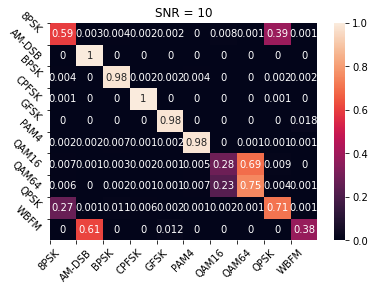

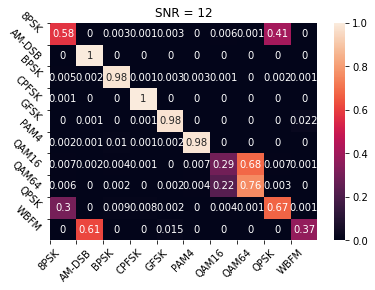

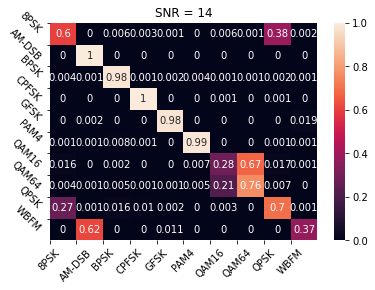

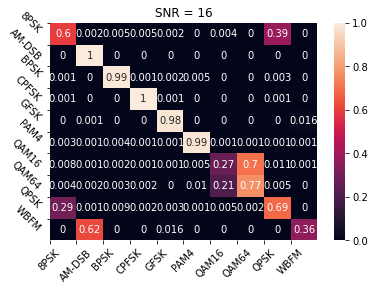

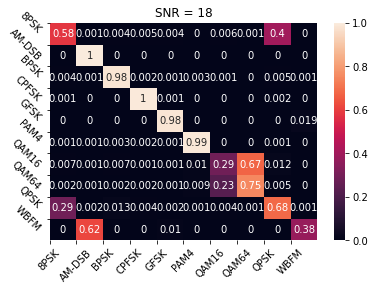

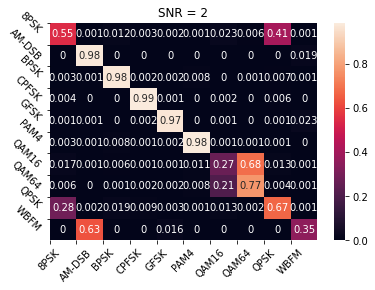

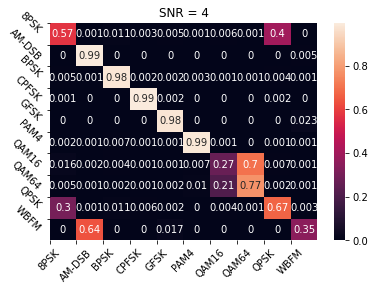

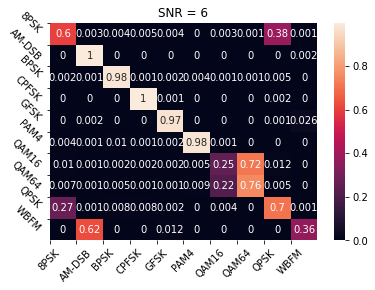

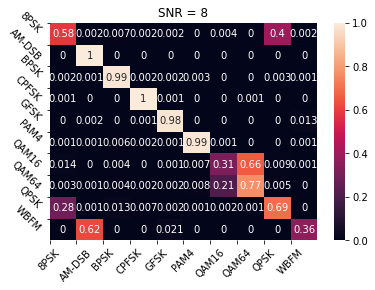

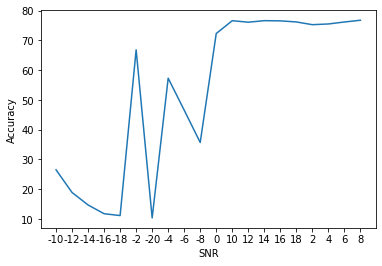

In [33]:
eval_model(cnn_model,x_test,y_test,y_test_encoded)

### CNN on X diff

In [19]:
x = np.gradient(X,axis=-1)
cnn_diff_model = create_cnn("cnn_diff",x.shape[1:]+(1,))

KeyboardInterrupt: 

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [ ]:
cnn_diff_history = train_and_plot(
    cnn_diff_model,
    "/kaggle/working/checkpoints/cnn",
    x_train.reshape(x_train.shape+(1,)),
    y_train_encoded,
    x_val.reshape(x_val.shape+(1,)),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

cnn_diff_model.load_weights("/kaggle/working/checkpoints/cnn")
cnn_diff_model.evaluate(x_val.reshape(x_val.shape+(1,)),y_val_encoded)

In [ ]:
eval_model(cnn_diff_model,x_test,y_test,y_test_encoded)

## RNN Model

In [10]:
def create_rnn(name,rnn_input_shape):
    # SimpleRNN model
    rnn_model = keras.Sequential()
    rnn_model.add(keras.layers.SimpleRNN(units=128, input_shape=(rnn_input_shape), activation="relu", return_sequences=True))
    rnn_model.add(keras.layers.SimpleRNN(units=64, activation="relu"))
    rnn_model.add(layers.Dense(units=10, activation="softmax"))
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = keras.losses.CategoricalCrossentropy()
    rnn_model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    print(rnn_model.summary())
    return rnn_model

In [22]:
x = X
rnn_model = create_rnn("rnn_2_ch",x.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 2, 128)            32896     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [24]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

In [32]:
print(x_train.shape[1:])
print(x.shape[1:])
print(x.shape[1:]+(1,))

(2, 128)


NameError: name 'x' is not defined

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 183s 7ms/step - loss: 1.5846 - accuracy: 0.3527 - val_loss: 1.4921 - val_accuracy: 0.3853
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 213s 9ms/step - loss: 1.4457 - accuracy: 0.4015 - val_loss: 1.4324 - val_accuracy: 0.4100
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 207s 8ms/step - loss: 1.3819 - accuracy: 0.4271 - val_loss: 1.3575 - val_accuracy: 0.4377
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 202s 8ms/step - loss: 1.3278 - accuracy: 0.4450 - val_loss: 1.3548 - val_a

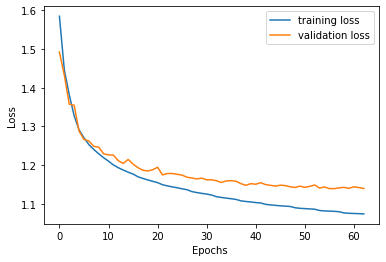

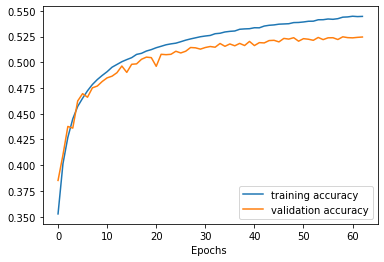

In [25]:
rnn_history = train_and_plot(
    rnn_model,
    "/kaggle/working/checkpoints/rnn",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [26]:
rnn_model.load_weights("/kaggle/working/checkpoints/rnn")
rnn_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 5s 4ms/step - loss: 1.1395 - accuracy: 0.5238


[1.1394648551940918, 0.523809552192688]

In [12]:
def eval_rnn_model(model,x,y,y_encoded):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x.reshape(x.shape))
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y_encoded,axis=-1)
    
    target_names = np.unique(y[:,0])
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    cm = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)
    sns.heatmap(cm,annot=True)
    plt.xticks(tick_marks, labels, rotation= 45)
    plt.yticks(tick_marks, labels, rotation=-45)
    
    plt.figure()
    snrs = np.unique(y[:,1])
    
    accuracies = np.zeros_like(snrs,dtype=np.float32)
    for i, snr in enumerate(snrs):
        idx = y[:,1] == snr
        cm = tf.math.confusion_matrix(y_numbers[idx],y_pred[idx]).numpy().astype(np.int64)
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=3)

        sns.heatmap(cm,annot=True)
        plt.title(f"SNR = {snr}")
        plt.xticks(tick_marks, labels, rotation= 45)
        plt.yticks(tick_marks, labels, rotation=-45)
        plt.show()
        plt.figure()
        accuracies[i] = np.count_nonzero(y_numbers[idx] == y_pred[idx]) / y_pred[idx].shape[0]
    
    plt.plot(snrs,np.around(accuracies * 100,2))
    plt.xlabel('SNR')
    plt.ylabel("Accuracy")
    plt.show()

              precision    recall  f1-score   support

        8PSK       0.42      0.38      0.40     36000
      AM-DSB       0.51      0.71      0.60     36000
        BPSK       0.48      0.67      0.56     36000
       CPFSK       0.67      0.62      0.64     36000
        GFSK       0.64      0.71      0.67     36000
        PAM4       0.74      0.68      0.71     36000
       QAM16       0.41      0.30      0.34     36000
       QAM64       0.53      0.41      0.46     36000
        QPSK       0.34      0.41      0.37     36000
        WBFM       0.49      0.33      0.39     36000

    accuracy                           0.52    360000
   macro avg       0.52      0.52      0.51    360000
weighted avg       0.52      0.52      0.51    360000



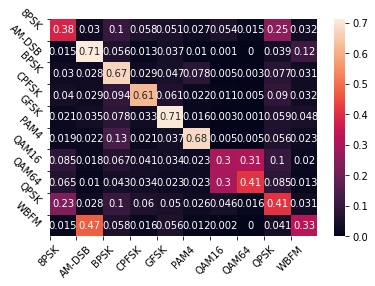

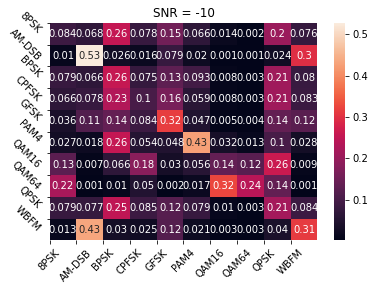

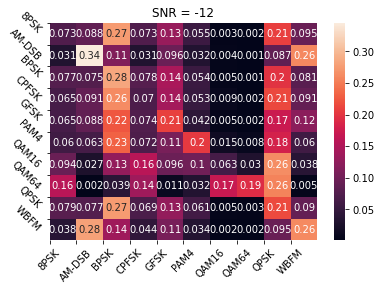

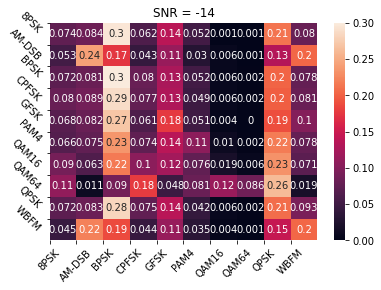

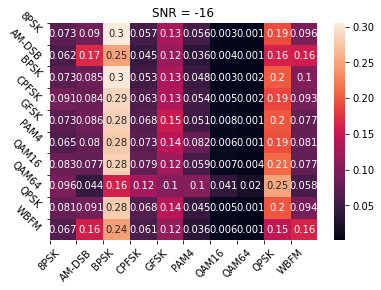

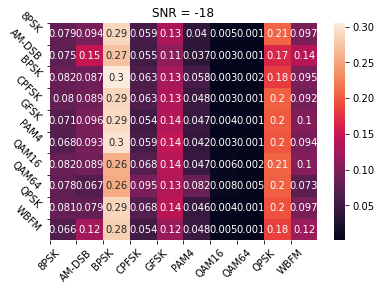

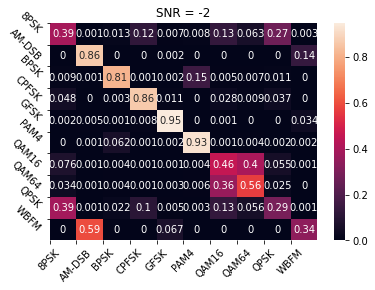

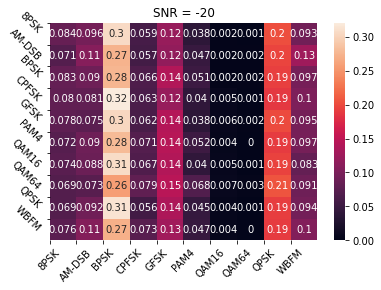

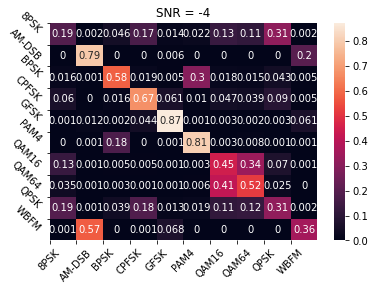

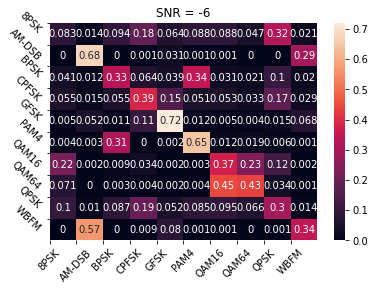

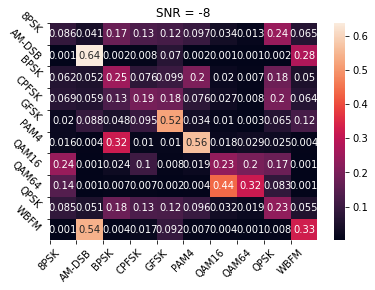

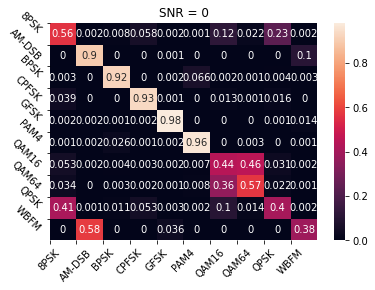

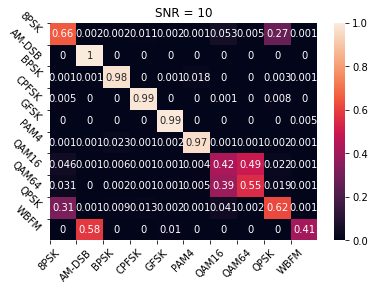

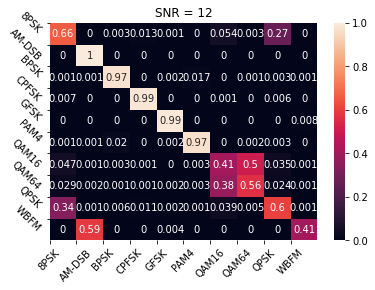

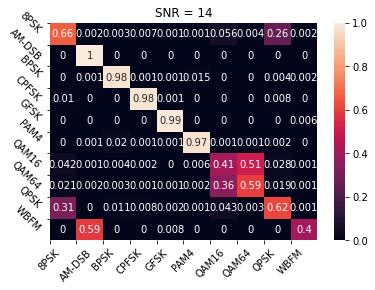

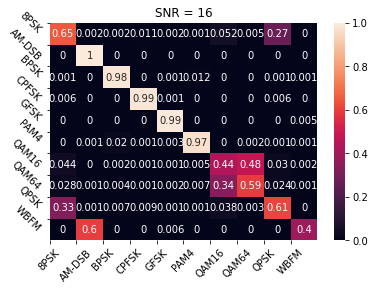

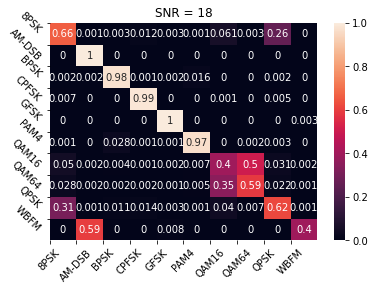

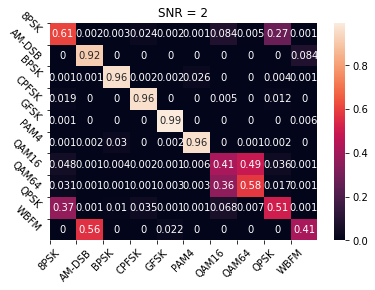

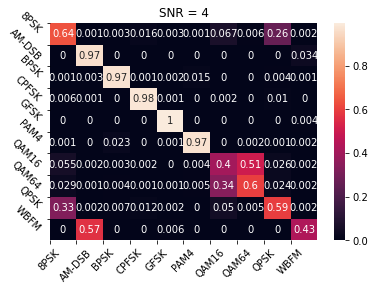

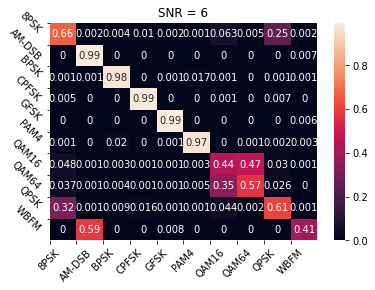

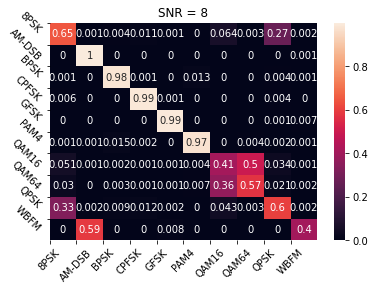

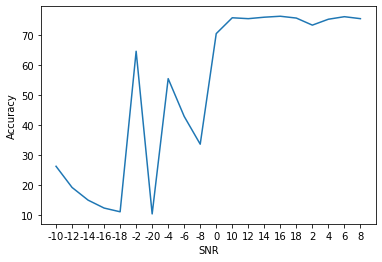

In [28]:
eval_rnn_model(rnn_model,x_test,y_test,y_test_encoded)

## RNN with Differentiated Data

In [33]:
x = np.gradient(X,axis=-1)
rnn_diff_model = create_rnn("rnn_diff",x.shape[1:])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 2, 128)            32896     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [35]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0008, shape=(), dtype=float64).
24938/24938 [==============================] - 186s 7ms/step - loss: 2.2611 - accuracy: 0.1277 - val_loss: 2.1295 - val_accuracy: 0.1645
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0008, shape=(), dtype=float64).
24938/24938 [==============================] - 183s 7ms/step - loss: 1.8856 - accuracy: 0.2464 - val_loss: 1.7853 - val_accuracy: 0.2782
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0008, shape=(), dtype=float64).
24938/24938 [==============================] - 184s 7ms/step - loss: 1.7479 - accuracy: 0.2918 - val_loss: 1.7197 - val_accuracy: 0.3024
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0008, shape=(), dtype=float64).
24938/24938 [==============================] - 189s 8ms/step - loss: 1.6850 - accuracy: 0.3120 - val_loss: 1.6617 - val_accur

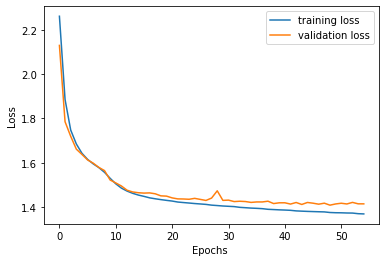

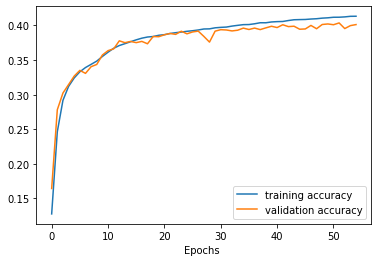

In [36]:
rnn_diff_history = train_and_plot(
    rnn_diff_model,
    "/kaggle/working/checkpoints/rnn_diff",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [37]:
rnn_diff_model.load_weights("/kaggle/working/checkpoints/rnn_diff")
rnn_diff_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 6s 4ms/step - loss: 1.4090 - accuracy: 0.4014


[1.4090381860733032, 0.40142858028411865]

              precision    recall  f1-score   support

        8PSK       0.20      0.14      0.16     36000
      AM-DSB       0.36      0.69      0.47     36000
        BPSK       0.45      0.35      0.40     36000
       CPFSK       0.50      0.62      0.56     36000
        GFSK       0.57      0.64      0.60     36000
        PAM4       0.57      0.52      0.54     36000
       QAM16       0.25      0.06      0.10     36000
       QAM64       0.36      0.46      0.40     36000
        QPSK       0.21      0.25      0.23     36000
        WBFM       0.41      0.28      0.33     36000

    accuracy                           0.40    360000
   macro avg       0.39      0.40      0.38    360000
weighted avg       0.39      0.40      0.38    360000



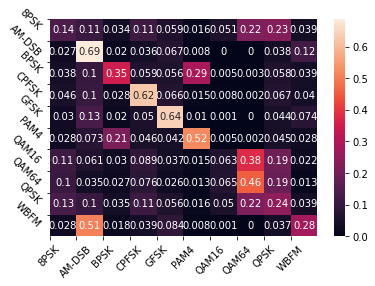

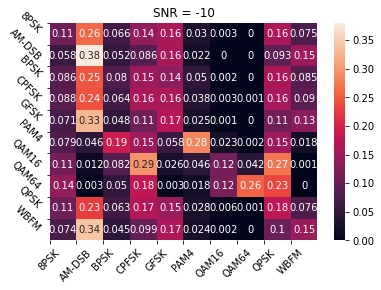

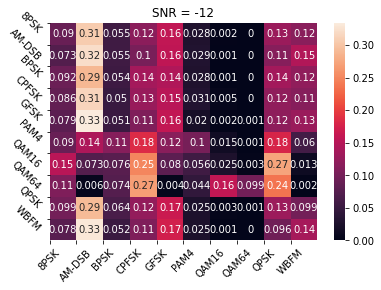

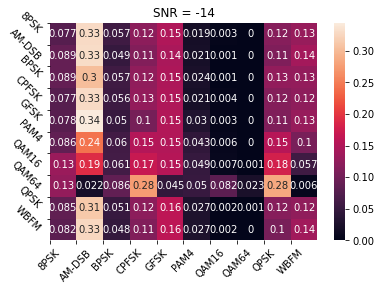

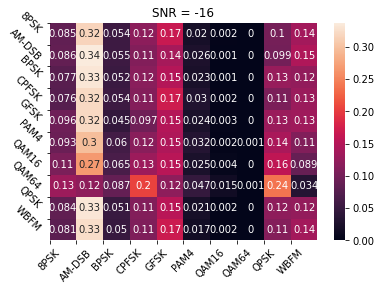

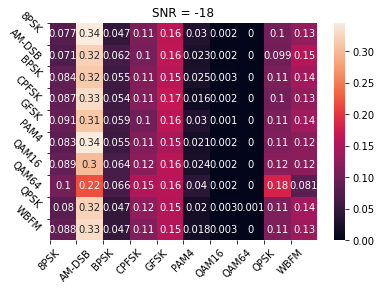

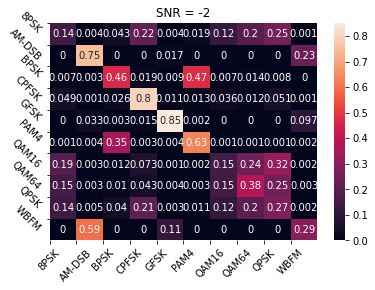

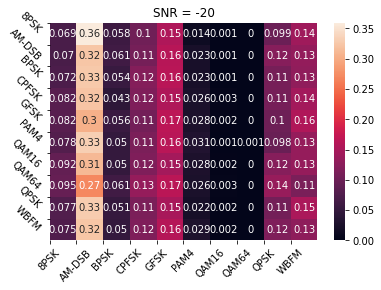

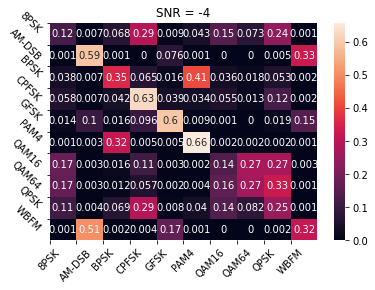

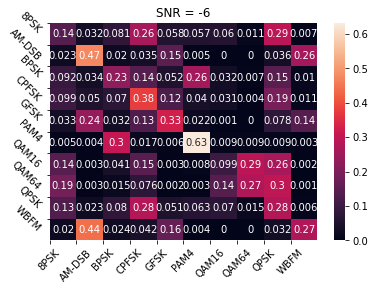

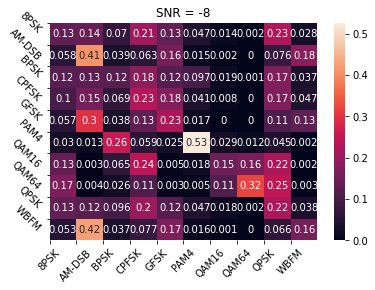

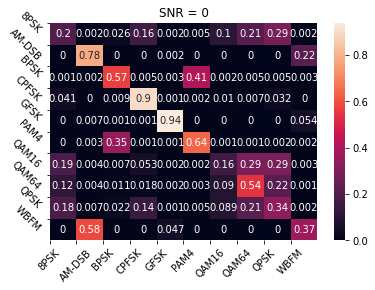

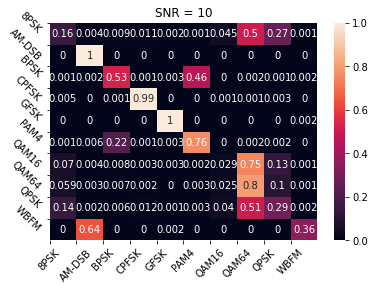

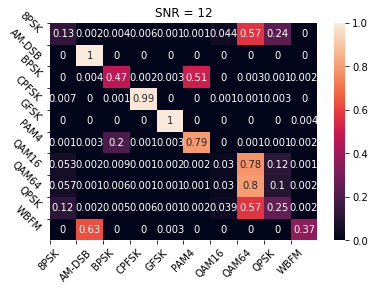

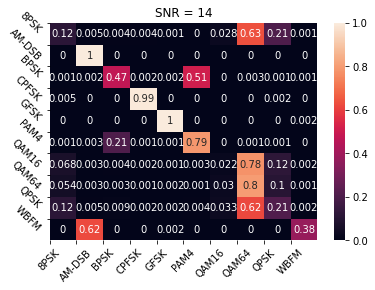

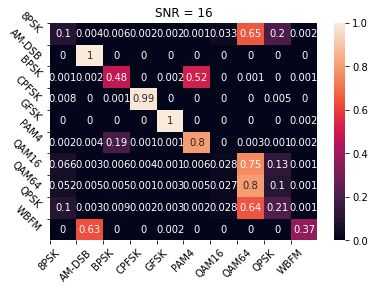

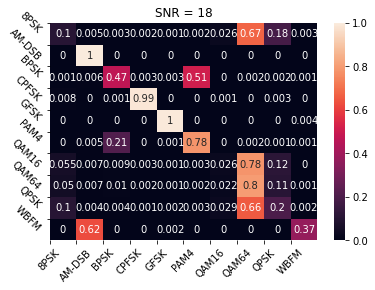

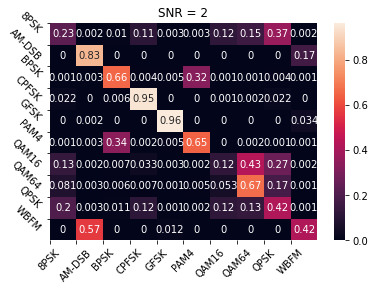

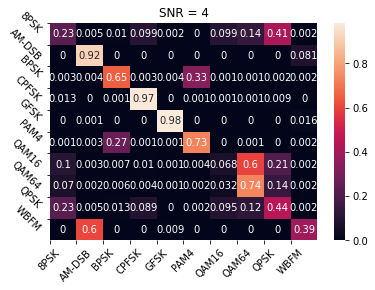

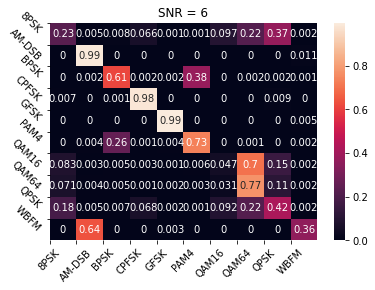

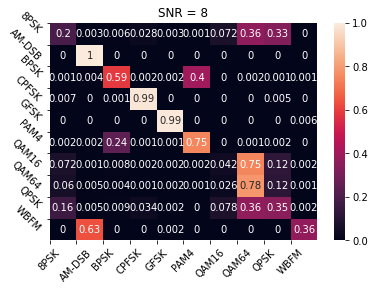

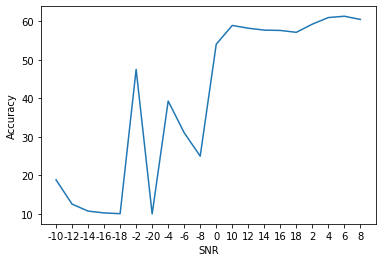

In [38]:
eval_rnn_model(rnn_diff_model,x_test,y_test,y_test_encoded)

## RNN with integrated data

In [12]:
X_int = np.zeros_like(X)
X_int[:,:,:-1] = np.array(cumulative_trapezoid(X))

In [13]:
x = X_int
rnn_int_model = create_rnn("rnn_int",x.shape[1:])

2023-01-20 21:17:22.654771: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 2, 128)            32896     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [15]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2023-01-20 21:17:51.718023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 134s 5ms/step - loss: 1.6254 - accuracy: 0.3265 - val_loss: 1.5062 - val_accuracy: 0.3658
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 130s 5ms/step - loss: 1.4537 - accuracy: 0.3877 - val_loss: 1.4191 - val_accuracy: 0.4035
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 127s 5ms/step - loss: 1.3968 - accuracy: 0.4129 - val_loss: 1.3793 - val_accuracy: 0.4225
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 128s 5ms/step - loss: 1.3633 - accuracy: 0.4266 - val_loss: 1.3531 - val_accur

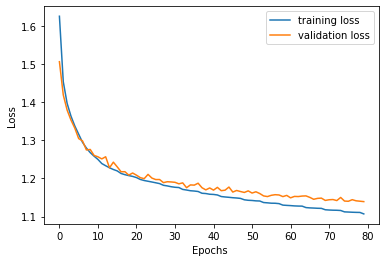

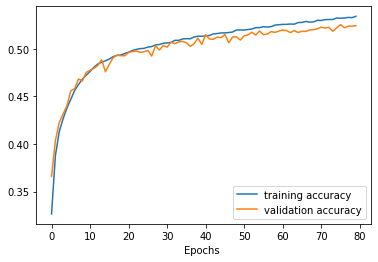

In [16]:
rnn_int_history = train_and_plot(
    rnn_int_model,
    "/kaggle/working/checkpoints/rnn_int",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [17]:
rnn_int_model.load_weights("/kaggle/working/checkpoints/rnn_int")
rnn_int_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 4s 3ms/step - loss: 1.1392 - accuracy: 0.5242


[1.1392089128494263, 0.524238109588623]

              precision    recall  f1-score   support

        8PSK       0.37      0.41      0.39     36000
      AM-DSB       0.49      0.77      0.60     36000
        BPSK       0.54      0.64      0.59     36000
       CPFSK       0.66      0.62      0.64     36000
        GFSK       0.67      0.70      0.68     36000
        PAM4       0.76      0.68      0.72     36000
       QAM16       0.42      0.14      0.21     36000
       QAM64       0.51      0.51      0.51     36000
        QPSK       0.32      0.47      0.38     36000
        WBFM       0.63      0.27      0.38     36000

    accuracy                           0.52    360000
   macro avg       0.54      0.52      0.51    360000
weighted avg       0.54      0.52      0.51    360000



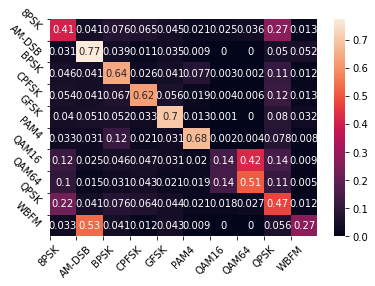

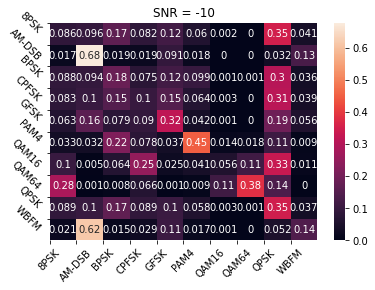

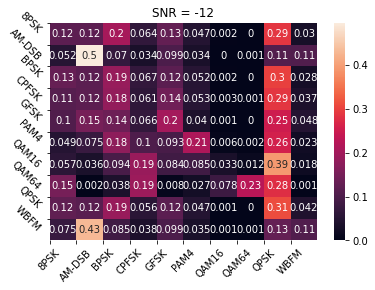

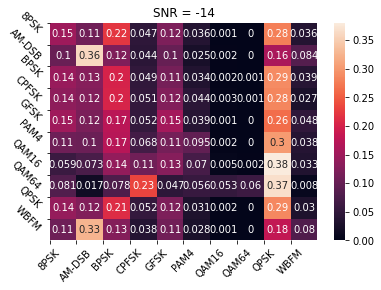

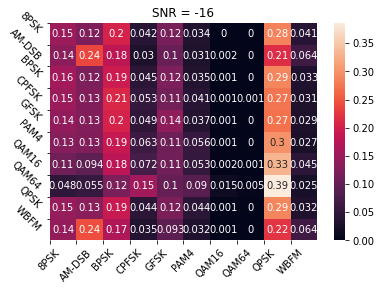

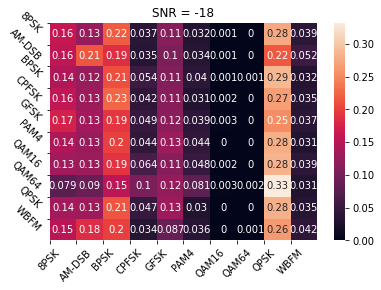

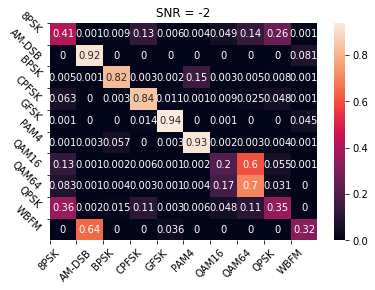

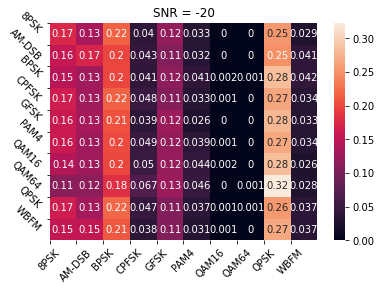

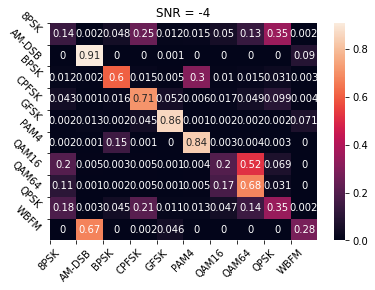

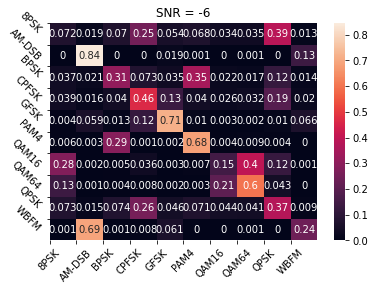

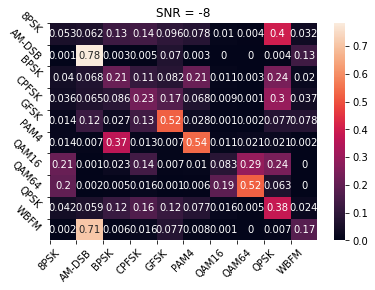

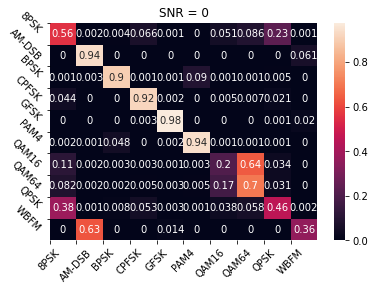

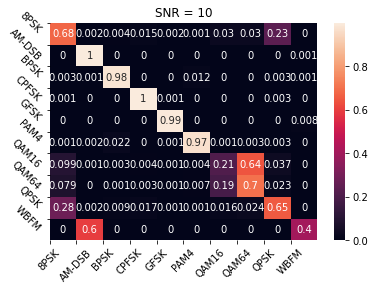

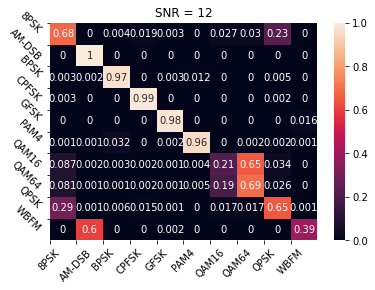

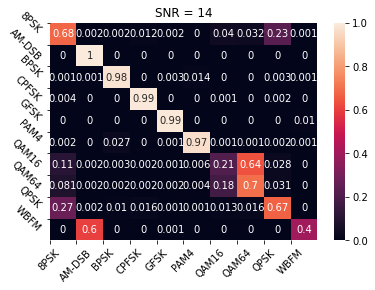

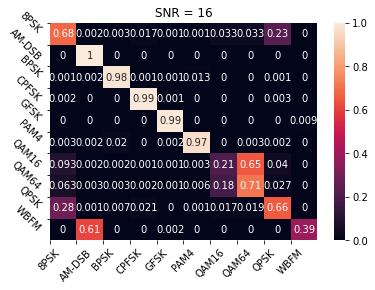

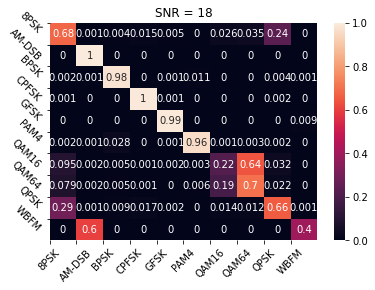

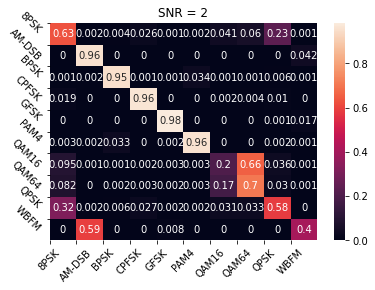

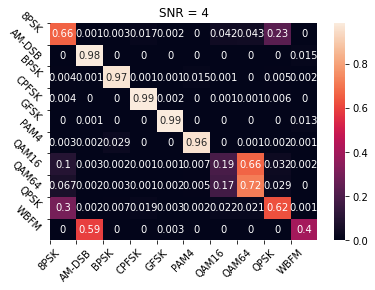

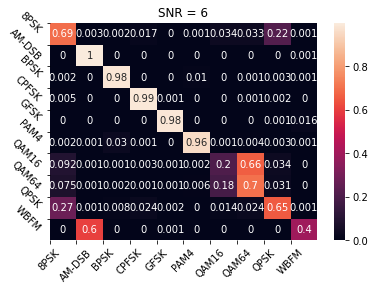

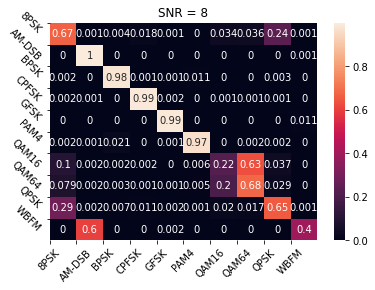

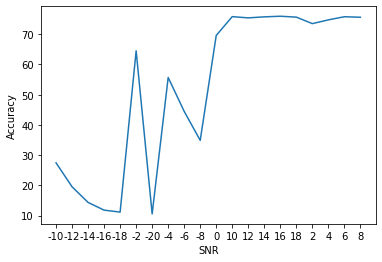

In [18]:
eval_rnn_model(rnn_int_model,x_test,y_test,y_test_encoded)

## RNN with Raw & Differentiated Data

In [20]:
x = X_raw_diff
rnn_raw_diff_model = create_rnn("rnn_raw_diff",x.shape[1:])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [22]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 201s 8ms/step - loss: 1.5169 - accuracy: 0.3715 - val_loss: 1.4301 - val_accuracy: 0.4026
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 203s 8ms/step - loss: 1.3685 - accuracy: 0.4246 - val_loss: 1.3261 - val_accuracy: 0.4405
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 194s 8ms/step - loss: 1.3150 - accuracy: 0.4457 - val_loss: 1.2973 - val_accuracy: 0.4553
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 204s 8ms/step - loss: 1.2923 - accuracy: 0.4557 - val_loss: 1.2809 - val_accur

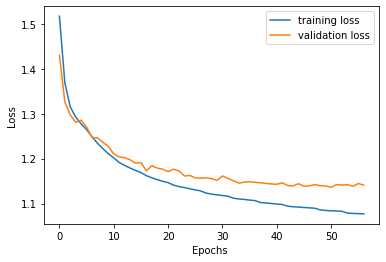

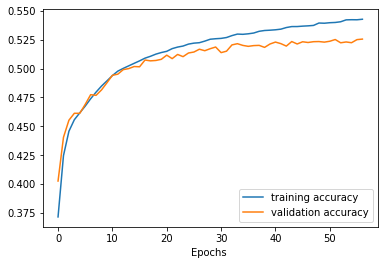

In [23]:
rnn_raw_diff_history = train_and_plot(
    rnn_raw_diff_model,
    "/kaggle/working/checkpoints/rnn_raw_diff",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [24]:
rnn_raw_diff_model.load_weights("/kaggle/working/checkpoints/rnn_raw_diff")
rnn_raw_diff_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 6s 4ms/step - loss: 1.1362 - accuracy: 0.5237


[1.1362481117248535, 0.5236666798591614]

              precision    recall  f1-score   support

        8PSK       0.29      0.48      0.36     36000
      AM-DSB       0.47      0.72      0.57     36000
        BPSK       0.49      0.65      0.56     36000
       CPFSK       0.71      0.61      0.66     36000
        GFSK       0.61      0.71      0.65     36000
        PAM4       0.80      0.68      0.74     36000
       QAM16       0.40      0.30      0.34     36000
       QAM64       0.52      0.42      0.46     36000
        QPSK       0.52      0.32      0.40     36000
        WBFM       0.67      0.32      0.43     36000

    accuracy                           0.52    360000
   macro avg       0.55      0.52      0.52    360000
weighted avg       0.55      0.52      0.52    360000



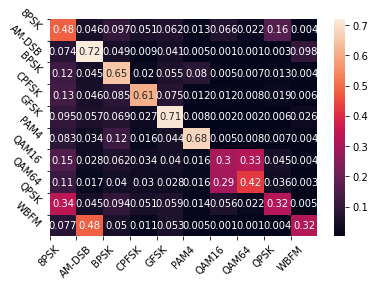

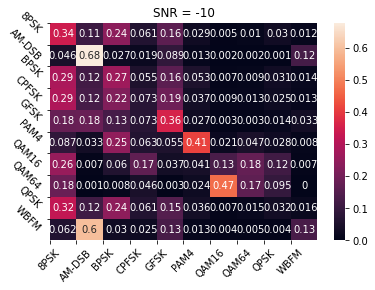

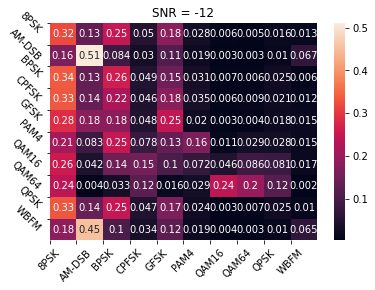

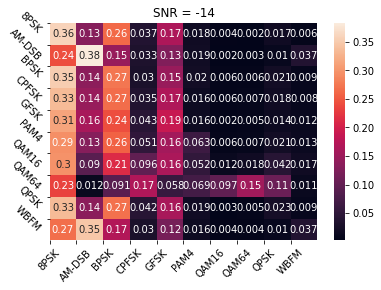

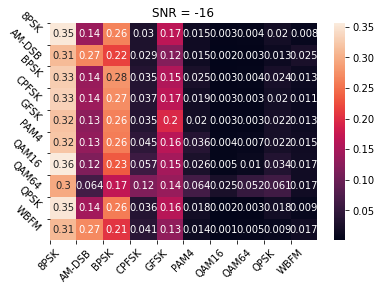

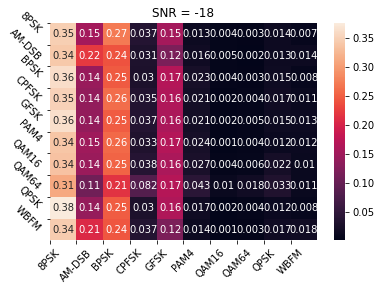

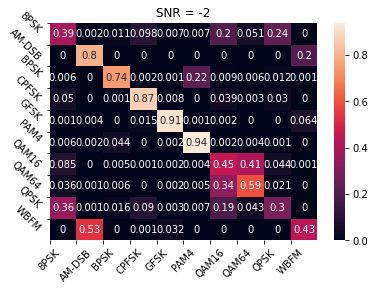

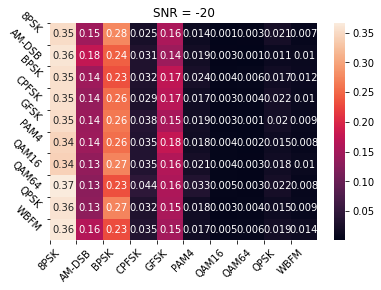

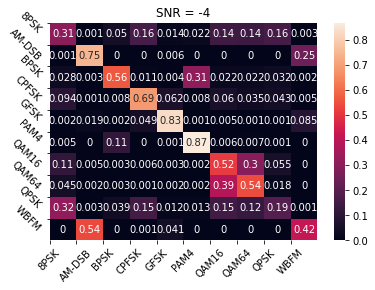

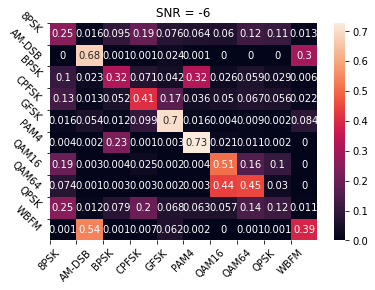

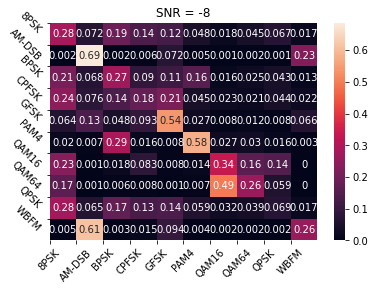

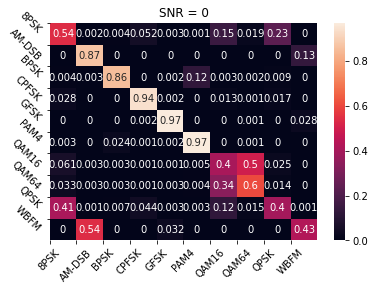

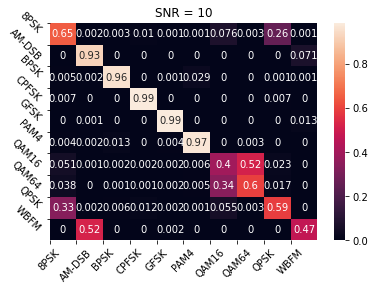

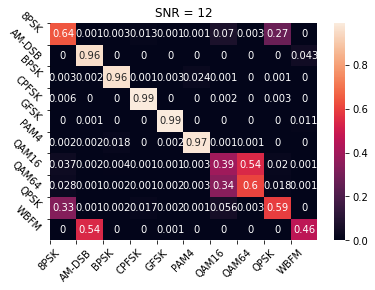

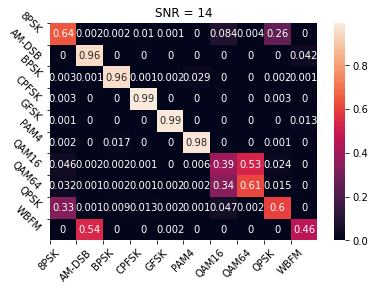

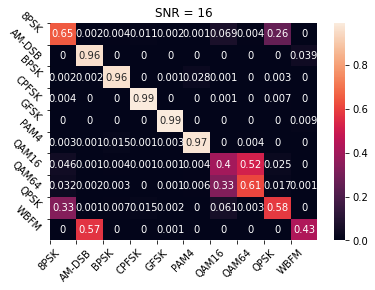

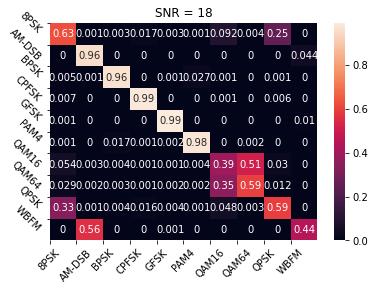

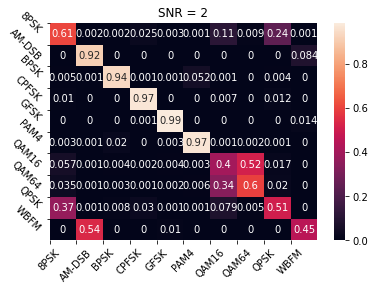

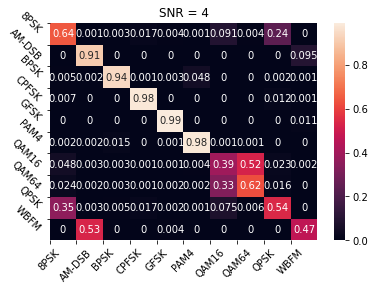

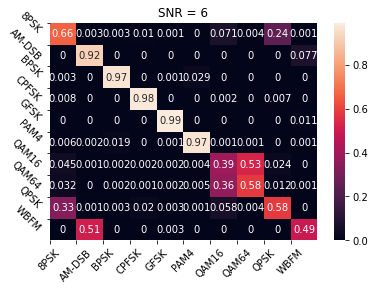

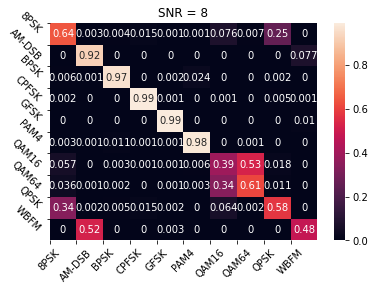

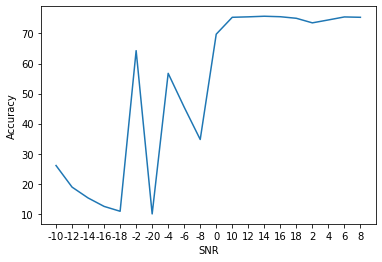

In [25]:
eval_rnn_model(rnn_raw_diff_model,x_test,y_test,y_test_encoded)

## RNN with Raw & Integrated Data

In [15]:
x = X_raw_int
rnn_raw_int_model = create_rnn("rnn_raw_int",x.shape[1:])

2023-01-21 19:46:23.647382: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4, 128)            32896     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [17]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2023-01-21 19:46:38.103518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 202s 8ms/step - loss: 1.5984 - accuracy: 0.3371 - val_loss: 1.4227 - val_accuracy: 0.3955
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 202s 8ms/step - loss: 1.3809 - accuracy: 0.4143 - val_loss: 1.3491 - val_accuracy: 0.4238
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 202s 8ms/step - loss: 1.3303 - accuracy: 0.4381 - val_loss: 1.3291 - val_accuracy: 0.4407
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 205s 8ms/step - loss: 1.3028 - accuracy: 0.4496 - val_loss: 1.2951 - val_accur

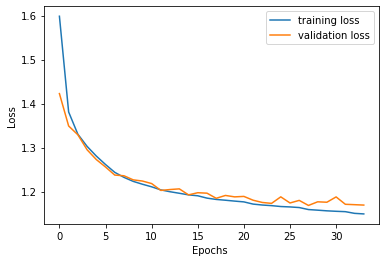

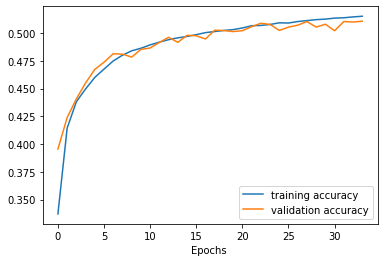

In [18]:
rnn_raw_int_history = train_and_plot(
    rnn_raw_int_model,
    "/kaggle/working/checkpoints/rnn_raw_int",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [19]:
rnn_raw_int_model.load_weights("/kaggle/working/checkpoints/rnn_raw_int")
rnn_raw_int_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 5s 4ms/step - loss: 1.1685 - accuracy: 0.5103


[1.1685495376586914, 0.5102857351303101]

              precision    recall  f1-score   support

        8PSK       0.37      0.34      0.35     36000
      AM-DSB       0.47      0.79      0.59     36000
        BPSK       0.66      0.59      0.63     36000
       CPFSK       0.67      0.61      0.64     36000
        GFSK       0.71      0.69      0.70     36000
        PAM4       0.83      0.64      0.72     36000
       QAM16       0.41      0.15      0.22     36000
       QAM64       0.51      0.45      0.48     36000
        QPSK       0.24      0.53      0.33     36000
        WBFM       0.73      0.26      0.38     36000

    accuracy                           0.51    360000
   macro avg       0.56      0.51      0.50    360000
weighted avg       0.56      0.51      0.50    360000



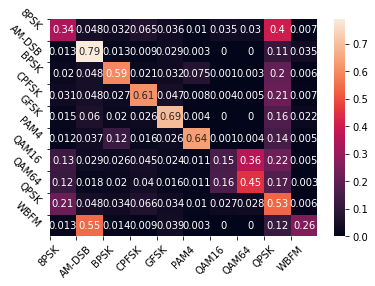

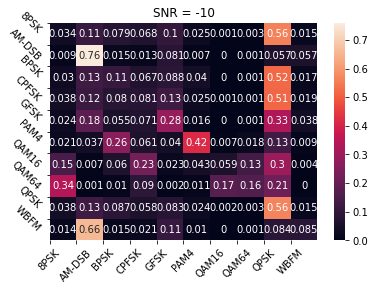

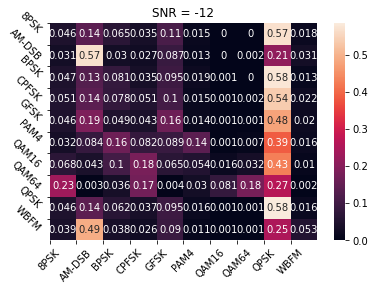

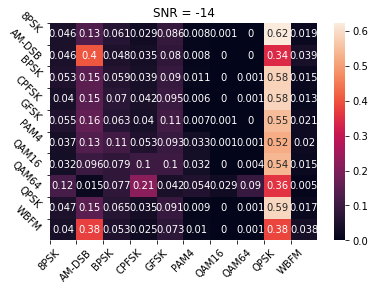

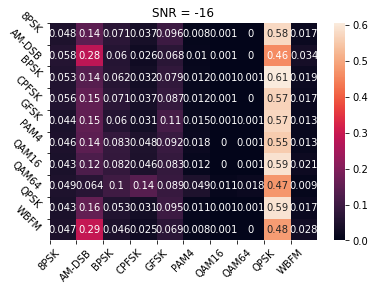

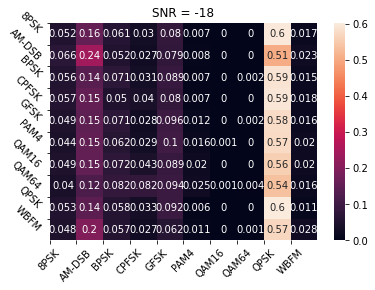

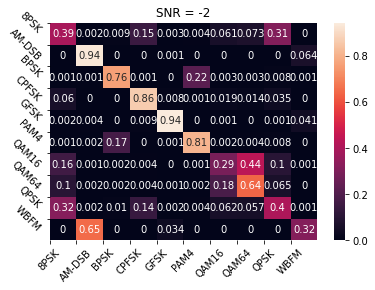

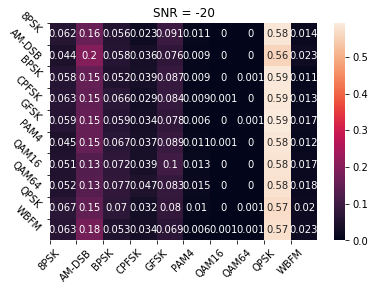

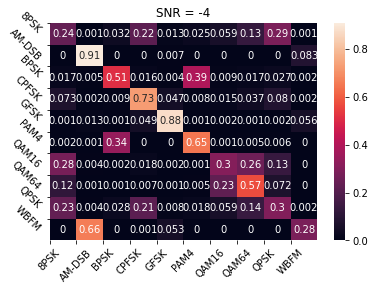

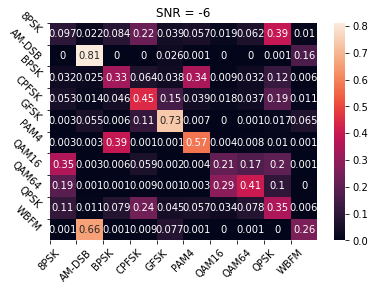

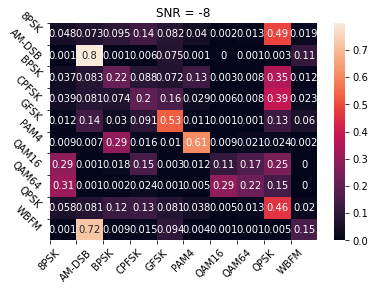

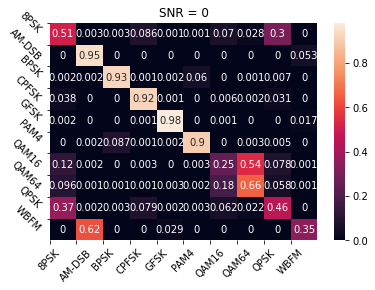

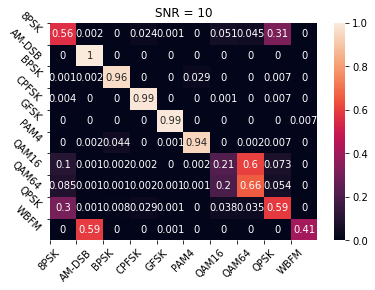

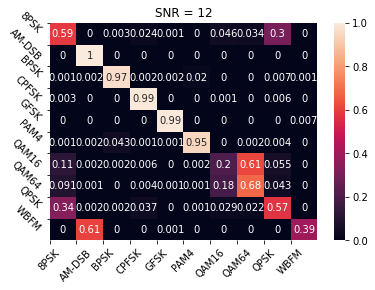

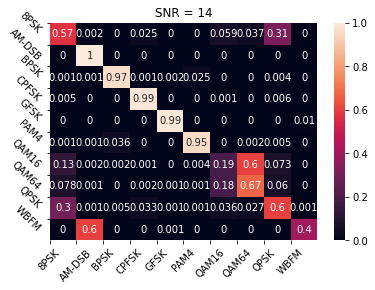

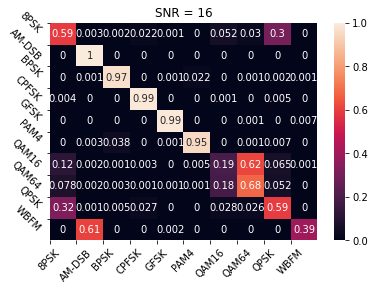

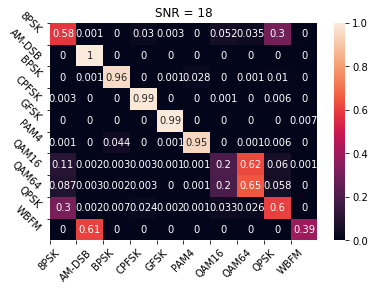

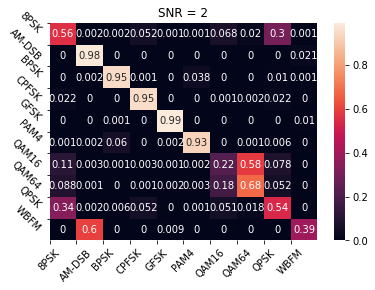

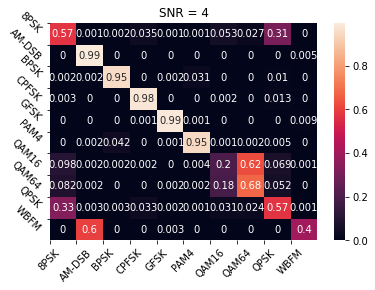

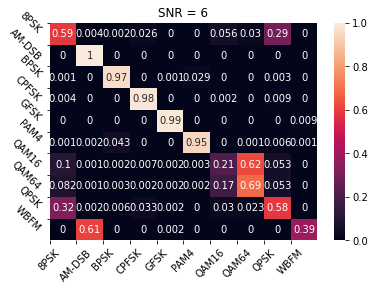

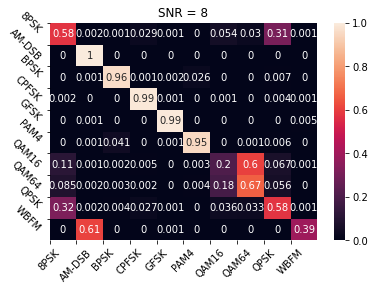

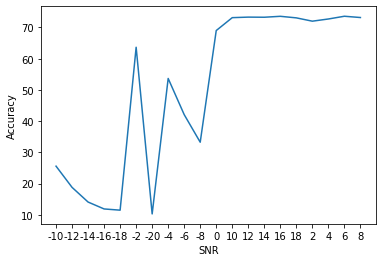

In [20]:
eval_rnn_model(rnn_raw_int_model,x_test,y_test,y_test_encoded)

## RNN with Differentiated & Integrated Data

In [12]:
x = X_diff_int
rnn_diff_int_model = create_rnn("rnn_diff_int",x.shape[1:])

2023-01-22 12:54:50.582594: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4, 128)            32896     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [14]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

2023-01-22 12:55:11.224002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 189s 7ms/step - loss: 1.6509 - accuracy: 0.3201 - val_loss: 1.5215 - val_accuracy: 0.3617
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 184s 7ms/step - loss: 1.4748 - accuracy: 0.3782 - val_loss: 1.4415 - val_accuracy: 0.3937
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 186s 7ms/step - loss: 1.4106 - accuracy: 0.4059 - val_loss: 1.3837 - val_accuracy: 0.4149
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 183s 7ms/step - loss: 1.3685 - accuracy: 0.4252 - val_loss: 1.3693 - val_accur

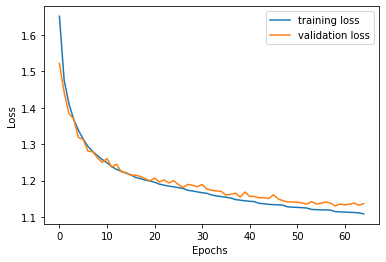

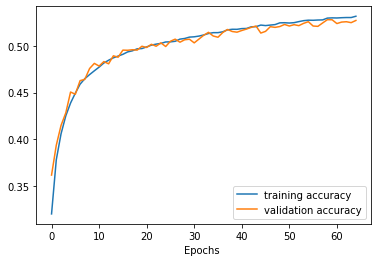

In [15]:
rnn_diff_int_history = train_and_plot(
    rnn_diff_int_model,
    "/kaggle/working/checkpoints/rnn_diff_int",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

In [16]:
rnn_diff_int_model.load_weights("/kaggle/working/checkpoints/rnn_diff_int")
rnn_diff_int_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

1313/1313 [==============================] - 5s 4ms/step - loss: 1.1301 - accuracy: 0.5281


[1.1301358938217163, 0.5281428694725037]

              precision    recall  f1-score   support

        8PSK       0.33      0.44      0.37     36000
      AM-DSB       0.51      0.65      0.57     36000
        BPSK       0.54      0.64      0.59     36000
       CPFSK       0.73      0.59      0.65     36000
        GFSK       0.54      0.74      0.62     36000
        PAM4       0.82      0.67      0.74     36000
       QAM16       0.34      0.14      0.20     36000
       QAM64       0.51      0.55      0.53     36000
        QPSK       0.52      0.38      0.44     36000
        WBFM       0.42      0.41      0.42     36000

    accuracy                           0.52    360000
   macro avg       0.53      0.52      0.51    360000
weighted avg       0.53      0.52      0.51    360000



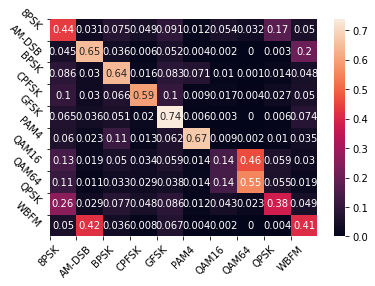

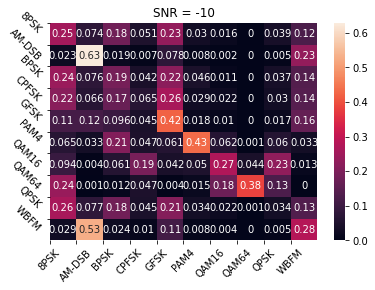

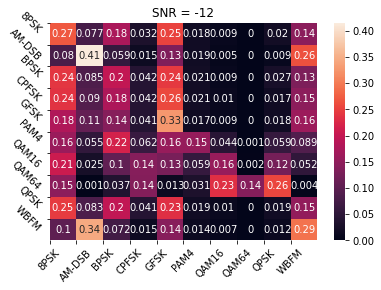

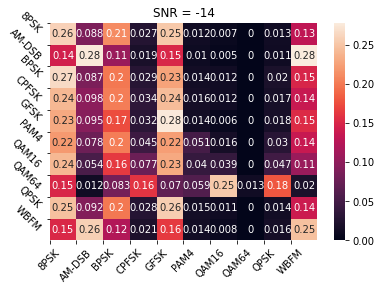

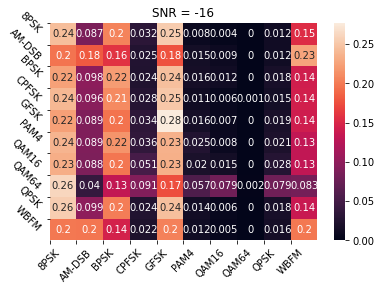

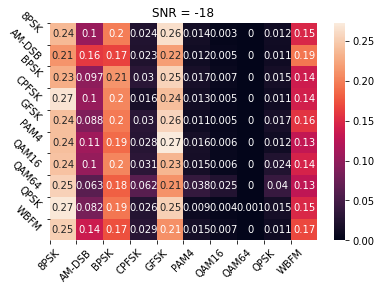

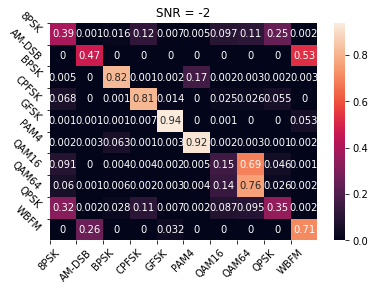

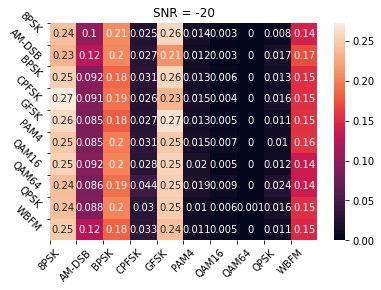

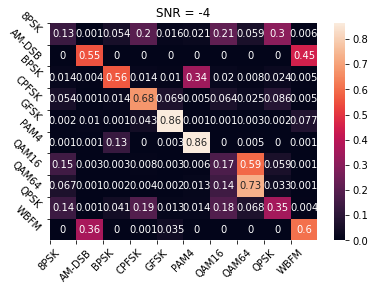

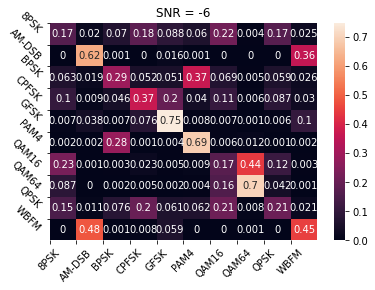

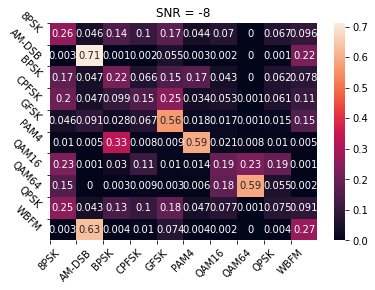

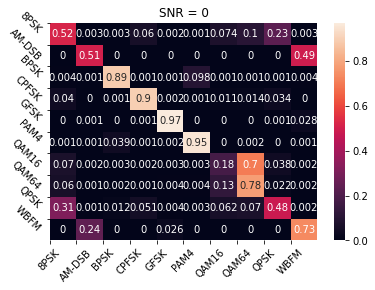

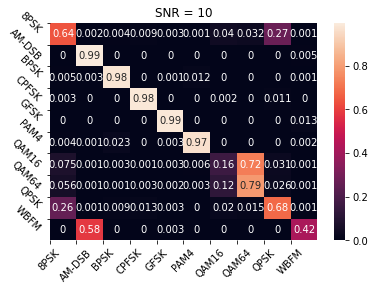

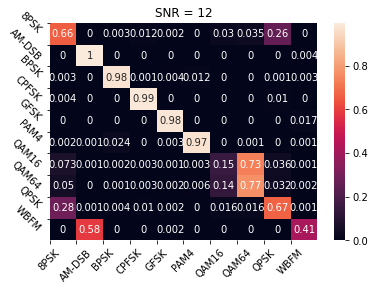

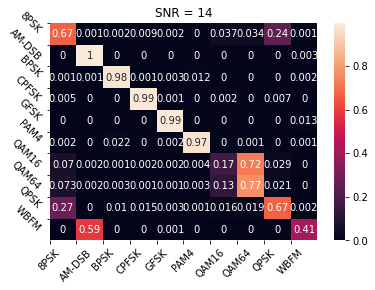

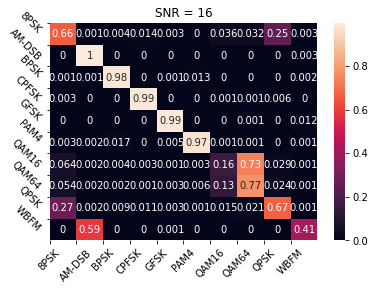

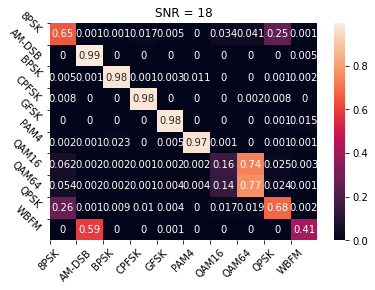

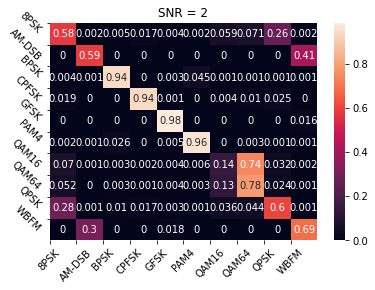

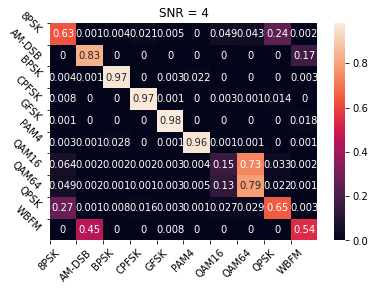

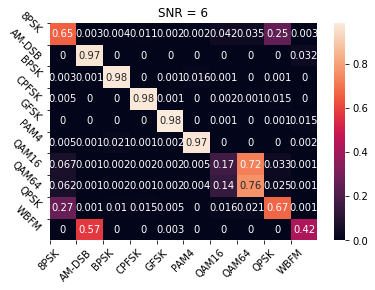

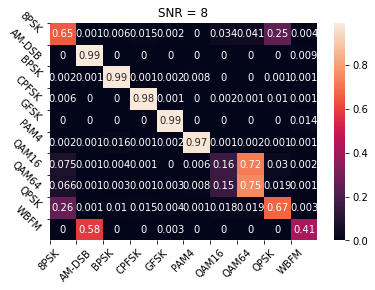

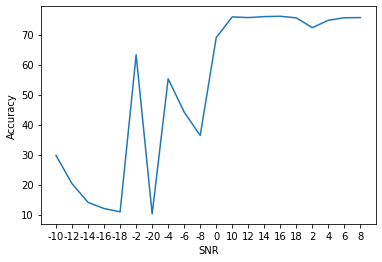

In [17]:
eval_rnn_model(rnn_diff_int_model,x_test,y_test,y_test_encoded)

## RNN with Raw & Differentiated & Integrated Data

In [13]:
x = X_all
rnn_all_model = create_rnn("rnn_all",x.shape[1:])

2023-01-25 07:51:38.358184: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 6, 128)            32896     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 45,898
Trainable params: 45,898
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
x_train, x_val, x_test, y_train, y_val, y_test = split(x,y)
del x

In [15]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_test[:,0].reshape(-1,1))
y_test_encoded = encoder.transform(y_test[:,0].reshape(-1,1))
y_train_encoded = encoder.transform(y_train[:,0].reshape(-1,1))
y_val_encoded = encoder.transform(y_val[:,0].reshape(-1,1))
y_test_encoded.shape

(360000, 10)

In [ ]:
rnn_all_history = train_and_plot(
    rnn_all_model,
    "/kaggle/working/checkpoints/rnn_all",
    x_train.reshape(x_train.shape),
    y_train_encoded,
    x_val.reshape(x_val.shape),
    y_val_encoded,
    epochs=EPOCHS
)
del x_train

2023-01-25 07:51:59.216252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 314s 13ms/step - loss: 1.5379 - accuracy: 0.3593 - val_loss: 1.3849 - val_accuracy: 0.4208
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 333s 13ms/step - loss: 1.3552 - accuracy: 0.4264 - val_loss: 1.3295 - val_accuracy: 0.4448
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 295s 12ms/step - loss: 1.3212 - accuracy: 0.4421 - val_loss: 1.3001 - val_accuracy: 0.4542
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009, shape=(), dtype=float64).
24938/24938 [==============================] - 296s 12ms/step - loss: 1.3000 - accuracy: 0.4510 - val_loss: 1.3003 - val_a

In [ ]:
rnn_all_model.load_weights("/kaggle/working/checkpoints/rnn_all")
rnn_all_model.evaluate(x_val.reshape(x_val.shape),y_val_encoded)

In [ ]:
eval_rnn_model(rnn_all_model,x_test,y_test,y_test_encoded)